In [297]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
import numpy as np
from scipy.spatial.distance import cdist

data = pd.read_csv('country.txt', delimiter=',')

data_clustering = data.drop('country', axis=1)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clustering)


# 1. use K-means clustering and Hierarchical clustering to cluster the country into groups. please choose the number of the cluster in a rational reason #

### K-Means ###

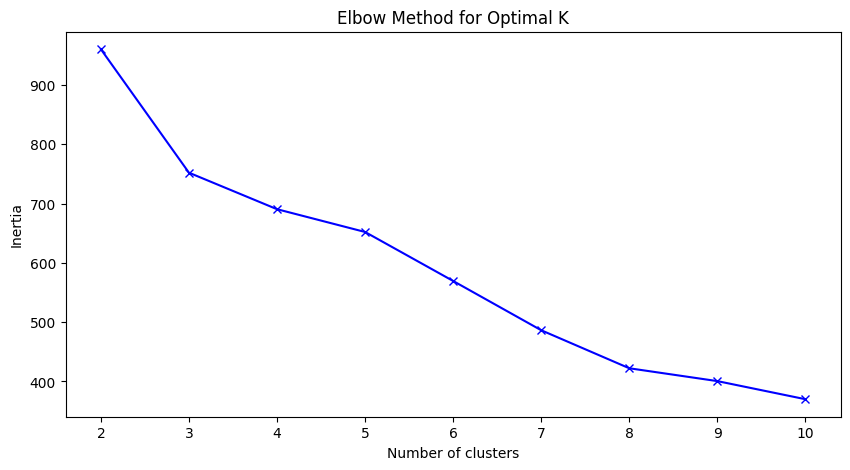

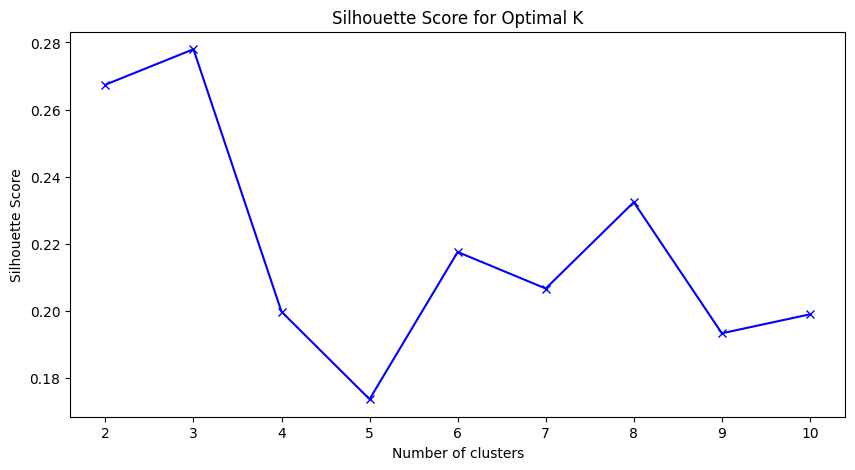

In [298]:
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_)) 

# elbow
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# silhouette
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)
kmeans_labels = kmeans.labels_
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

### Optimal number of clusters k = 3, because of significant inertia drop at k=3 and peak at k=3 in silhouette. ###

### Hierarchical Clustering ###

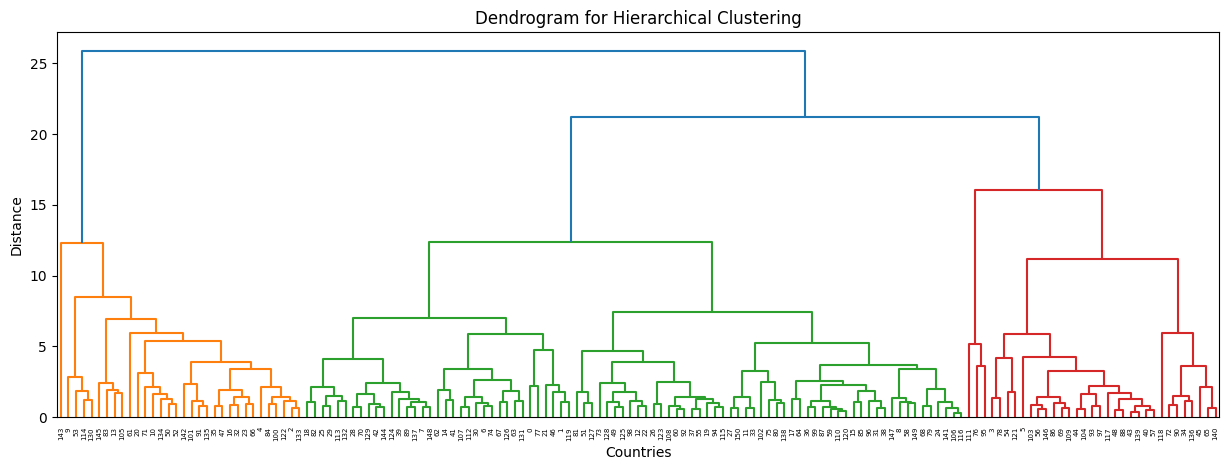

In [299]:
hierclus = linkage(data_scaled, method='ward')

plt.figure(figsize=(15, 5))
dendrogram(hierclus)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Countries')
plt.ylabel('Distance') 
plt.show()

hierarchical_labels = fcluster(hierclus, t=3, criterion='maxclust')


# 2. use PCA to reduce the dimension to 2d, and visualize the cluster from K-means and Hierarchical clustering respectively #

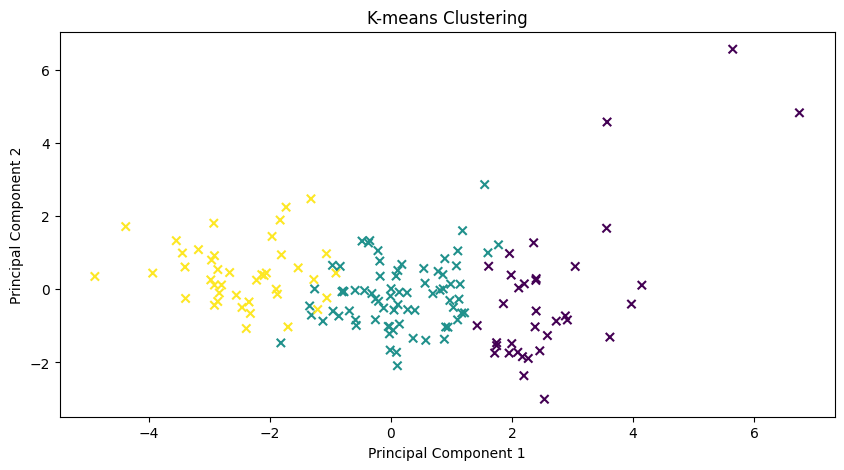

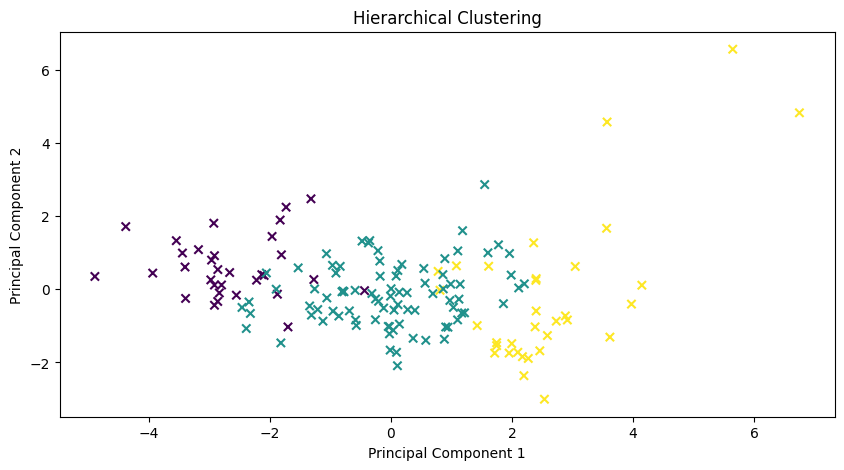

In [300]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# K-means
plt.figure(figsize=(10, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis', marker='x')
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# hierarchical
plt.figure(figsize=(10, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=hierarchical_labels, cmap='viridis', marker='x')
plt.title('Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# 3. please write the suggestion to CEO about the country you suggest #

In [301]:
data['KMeans_Cluster'] = kmeans.labels_

centroids = scaler.inverse_transform(kmeans.cluster_centers_)

def find_representative_country(cluster_number):
    cluster_data = data[data['KMeans_Cluster'] == cluster_number]
    cluster_data_clean = cluster_data.drop(['country', 'KMeans_Cluster'], axis=1)
    distances = cdist(cluster_data_clean, [centroids[cluster_number]])
    representative_index = np.argmin(distances)
    return cluster_data.iloc[representative_index]['country']

for i in range(3):
    rep_country = find_representative_country(i)
    print(f"Representative country for K-means Cluster {i}: {rep_country}")

Representative country for K-means Cluster 0: Belgium
Representative country for K-means Cluster 1: Montenegro
Representative country for K-means Cluster 2: Sudan


In [302]:
def is_worst_high(column_name):
    return column_name in ['child_mort', 'inflation', 'total_fer']

def is_worst_low(column_name):
    return column_name in ['life_expec', 'income', 'gdpp', 'health', 'imports', 'exports']

def find_worst_country(cluster_number, column_name):
    cluster_data = data[data['KMeans_Cluster'] == cluster_number]
    
    if is_worst_high(column_name):
        idx = cluster_data[column_name].idxmax()
    elif is_worst_low(column_name):
        idx = cluster_data[column_name].idxmin()
    else:
        raise ValueError(f"Wrong value: {column_name}")
    
    worst_country = cluster_data.loc[idx]
    return worst_country['country'], worst_country[column_name]

clusters = data['KMeans_Cluster'].unique()
columns = data.columns.difference(['country', 'KMeans_Cluster'])

for cluster_number in clusters:
    print(f"Cluster {cluster_number}:")
    for column_name in columns:
        country, value = find_worst_country(cluster_number, column_name)
        print(f"Worst country in K-means Cluster {cluster_number} based on {column_name}: {country} with value = {value}")
    
    print("-------------")

Cluster 1:
Worst country in K-means Cluster 1 based on child_mort: Myanmar with value = 64.4
Worst country in K-means Cluster 1 based on exports: Myanmar with value = 0.109
Worst country in K-means Cluster 1 based on gdpp: Nepal with value = 592
Worst country in K-means Cluster 1 based on health: Myanmar with value = 1.97
Worst country in K-means Cluster 1 based on imports: Myanmar with value = 0.0659
Worst country in K-means Cluster 1 based on income: Nepal with value = 1990
Worst country in K-means Cluster 1 based on inflation: Venezuela with value = 45.9
Worst country in K-means Cluster 1 based on life_expec: Vanuatu with value = 63.0
Worst country in K-means Cluster 1 based on total_fer: Samoa with value = 4.34
-------------
Cluster 2:
Worst country in K-means Cluster 2 based on child_mort: Haiti with value = 208.0
Worst country in K-means Cluster 2 based on exports: Timor-Leste with value = 2.2
Worst country in K-means Cluster 2 based on gdpp: Burundi with value = 231
Worst countr

In [303]:
data['KMeans_Cluster'] = kmeans_labels
data['Hierarchical_Cluster'] = hierarchical_labels

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
kmeans_analysis = data.groupby('KMeans_Cluster')[numeric_columns].mean()
hierarchical_analysis = data.groupby('Hierarchical_Cluster')[numeric_columns].mean()

print("K-means Cluster Analysis:\n", kmeans_analysis)
print("Hierarchical Cluster Analysis:\n", hierarchical_analysis)


K-means Cluster Analysis:
                 child_mort    exports    health    imports        income  \
KMeans_Cluster                                                             
0                 5.014286  58.360000  8.719429  51.145714  45677.142857   
1                21.985135  39.018770  6.064595  46.069809  12726.081081   
2                93.366667  28.035952  6.462143  42.852381   3866.261905   

                inflation  life_expec  total_fer          gdpp  
KMeans_Cluster                                                  
0                2.723343   80.111429   1.751714  42271.428571  
1                7.541568   72.986486   2.318108   6773.864865  
2               12.692738   59.095238   5.005476   1864.738095  
Hierarchical Cluster Analysis:
                       child_mort    exports    health    imports  \
Hierarchical_Cluster                                               
1                     102.056250  28.328750  6.812812  46.562500   
2                      26.27674

# Recommendations #

* KMeans Cluster 0, HierarchicalCluster 3: Developed countries with high income, low child mortality, high life expectancy, and low fertility rates. These countries may require less immediate attention in terms of basic socio-economic development. A recommendation would be to focus on development projects, technology transfers and innovation in healthcare and education. Representative country: Israel.
* KMeans Cluster 1, HierarchicalCluster 2: Developing countries with moderate income, moderate child mortality, and life expectancy. These countries could benefit from strategic investments in healthcare and education to boost overall development. Representative country: Samoa.
* KMeans Cluster 2, HierarchicalCluster 1: Least developed countries with low income, high child mortality, and low life expectancy. These countries should be prioritized for basic healthcare, nutrition, and education support to improve their overall development. Also ensuring contraceptives like condoms are available in the necessary quantities and at the right locations is crucial for a lower fertility rate. This includes access to health services, distribution channels, and inventory management. Representative country: Niger.

My recommendation would probably be to invest in Haiti, Niger and Pakistan. These are the countries which have the worst values in very important features like child mortality, health, life expectancy and total fertility. Because child mortality and life expectancy is the worst in Haiti, I would priorize this country. 

Again:

Worst country in K-means Cluster 2 based on child_mort: Haiti with value = 208.0
Worst country in K-means Cluster 2 based on exports: Timor-Leste with value = 2.2
Worst country in K-means Cluster 2 based on gdpp: Burundi with value = 231
Worst country in K-means Cluster 2 based on health: Pakistan with value = 2.2
Worst country in K-means Cluster 2 based on imports: Sudan with value = 17.2
Worst country in K-means Cluster 2 based on income: Congo, Dem. Rep. with value = 609
Worst country in K-means Cluster 2 based on inflation: Nigeria with value = 104.0
Worst country in K-means Cluster 2 based on life_expec: Haiti with value = 32.1
Worst country in K-means Cluster 2 based on total_fer: Niger with value = 7.49